In [1]:
from random import random
from funcoes import sigmoid, sigmoid_derivative, relu, relu_derivative
from matplotlib import pyplot as plt

import numpy as np
import ipdb

In [2]:
def one_hot(y, tam):
    """
    Serve para converter uma clase em um vetor. Nesse vetor, uma das posições
    é o inteiro 1, e o resto é 0.
    
    Exemplos:
    a classe 0 vira [1, 0, 0]
    a classe 1 vira [0, 1, 0]
    a classe 2 vira [0, 0, 1]
    
    se eu jogar um input no MLP, e eu sei que pra esse input a resposta certa
    é da classe 2, então eu vou dizer que na saída eu espero que tenha [0, 0, 1]
    """
    
    resultado = [0] * tam
    
    resultado[y] = 1
    
    return resultado

def erro_total(a: np.array, b: np.array):
    """
    calcula o erro total entre a e b. Um deles deve ser uma saída esperada,
    e o outro deve ser a saída obtida.
    
    O erro total é a somatória do quadrado das diferenças, algo como:
    (a1 - b1)^2 + (a2 - b2)^2 + ...
    """
    
    return sum((a-b)**2)
    

def gerar_um_peso():
    """Sorteia um número entre -1 e 1"""
    sinal, numero = random(), random()
    
    if sinal >= 0.5:
        return numero
    else:
        return -numero
    
def gerar_N_pesos(n: int):
    """Gera um array de números sorteados"""
    return np.array([gerar_um_peso() for i in range(n)])

def gerar_rede(dimensoes: list, biases: list = None):
    """
    Recebe a quantidade de neurônios em cada camada. Recebe uma lista de booleanos
    indicando se deve ter um bias em cada camada de pesos. Se nada for passado,
    assumimos que é pra ter bias em todas camadas.
    Gera pesos aleatoriamente.
    
    Observação: camadas de neurônios é uma coisa, camada de pesos é outra
    se eu tiver duas camadas de neurônios, eu tenho uma camada de pesos, que 
    liga essas duas camadas de neurônios
    
    O retorno é no formato
    
    [ <-- no primeiro nível, temos uma lista de camadas de pesos
    
        [ <-- para cada camada, temos uma lista de neurônios
        
            [ <-- para cada neurônio, temos uma lista de pesos
            
                0.2, 0.1, ...
            ]
        ]
    ]
    
    exemplo: gerar_rede([1,1]) gera pesos para uma rede com duas camadas de neurônios,
    com um neurônio em cada camada. Se temos duas camadas de neurônios, vamos ter uma camada
    de pesos.
    
    Resultado:
    rede = gerar_rede([1,1])  # [[[0.5]]], que é uma lista de camadas
    print(rede[0])            # [[0.5]]  , que é a lista de neurônios para a primeira camada
    print(rede[0][0])         # [0.5]    , que é a lista de pesos para o primeiro neurônio na primeira camada
    print(rede[0][0][0])      # 0.5      , que é o primeiro peso do primeiro neurônio da primeira camada
    """
    rede = []
    
    if not biases:
        biases = [True] * (len(dimensoes) - 1)
    
    for i in range(1, len(dimensoes)):
        if biases[i-1]:
            # se é pra ter bias nessa camada, eu gero um peso a mais
            pesos = [ gerar_N_pesos(dimensoes[i-1] + 1) for _ in range(dimensoes[i]) ]
        else:
            # não é pra ter bias: eu não gero um peso a mais
            pesos = [ gerar_N_pesos(dimensoes[i-1]) for _ in range(dimensoes[i]) ]
            
        rede.append( np.array(pesos) )
        
    return rede

def printar_rede(rede: list):
    """Printa as camadas de pesos da rede"""
    
    for i,camada in enumerate(rede):
        print("Camada %d:" % i)
        for j,neuronio in enumerate(camada):
            print("\tNeurônio %d:" % j)
            for w, peso in enumerate(neuronio):
                print("\t\tPeso %d:  %.6f" % (w, peso))
                
def forward(rede: list, entrada: np.array, biases: list = None):
    """
    Pega a entrada, e faz todos os cálculos pra obter a saída. Recebe uma lista de booleanos
    indicando se deve ter um bias em cada camada de pesos. Se nada for passado,
    assumimos que é pra ter bias em todas camadas.
    Assim, faz as multiplicações pelos pesos, joga nas funções
    de ativação, e passa em todas camadas, pra retornar o que sobra
    na camada de saída.
    
    O retorno é uma tupla.
    
    O primeiro elemento são os resultados das multiplicações
    das entradas pelos pesos (para cada camada), antes de aplicar a função de ativação.
    
    O segundo elemento é a mesma coisa que o primeiro, só que após a aplicação na função
    de ativação.
    """
    
    dados = entrada
    
    # Vai guardar os resultados das multiplicações das entradas pelos pesos
    # (antes de jogar nas funções de ativação)
    somas_ponderadas = []
    # Vai guardar a mesma coisa que somas_ponderadas, só que depois de passar
    # nas funções de ativação
    ativacoes = [entrada]
    
    if not biases:
        biases = [True] * (len(rede))
    
    for i,camada in enumerate(rede):
        # Decide se inclui o bias
        if biases[i]:
            # insere o inteiro '1' na posição 0
            dados = np.insert(dados, 0, 1)
        
        # Aplica a soma ponderada pelos pesos
        dados = np.sum(dados * camada, axis=1)
        somas_ponderadas.append(dados)
        
        # Aplica a função de ativação
        dados = sigmoid(dados)
        ativacoes.append(dados)
    
    return somas_ponderadas, ativacoes


def forward_backward(rede: list, entrada: np.array, desejados: np.array):
    """
    Realiza um ciclo de treinamento: faz o forward pass, obtendo a saída. Compara a saída com
    o desejado, obtendo o erro que indica qual deve ser o ajuste. Então propaga esse ajuste
    pela rede, com backpropagation.
    
    No final, retorna a nova rede de pesos atualizados
    """
    
    g_di = sigmoid_derivative # g_di é a derivada da função de ativação em relação a I
    nabla = 1 # taxa de aprendizado
    
    I, Y = forward(rede, entrada)
    
    """
    Ajuste da última camada
    """

    # vamos guardar todos os gradientes locais aqui. o primeiro item
    # são os gradientes da última camada, o segundo item da penúltima camada,
    # o terceiro da antepenúltima, etc...
    # isso é necessário porque, no backpropagation, o gradiente da última
    # camada é usado pra calcular o gradiente da penúltima, et cetera
    gradientes_locais = []

    # guardar só os gradientes da última camada
    ultimos_gradientes = []

    c = len(rede) - 1 # pegar a ultima camada

    for j in range(len(rede[c])):

        # no caso da última camada, fazemos desejado - obtido (d[j] - Y[c+1][j])
        gradiente_local_neuronio = (desejados[j] - Y[c+1][j]) * g_di(I[c][j])

        ultimos_gradientes.append(gradiente_local_neuronio)

        for i in range(len(rede[c][j])):
            if i == 0:
                # quando i == 0, estamos ajustando o peso do bias para o neurônio j.
                # nesse caso, fazemos esse * 1 no final
                rede[c][j][i] = rede[c][j][i] + nabla * gradiente_local_neuronio * 1
            else:
                # esse é o ajuste nos demais pesos, sem ser do bias.
                rede[c][j][i] = rede[c][j][i] + nabla * gradiente_local_neuronio * Y[c][i - 1]

    gradientes_locais.append(ultimos_gradientes)

    """
    Ajuste nas camadas escondidas
    """
    
    # vamos ir de trás pra frente: da penúltima camada de pesos até a primeira
    for c in reversed(range(len(rede) - 1)):
        camada = rede[c]
        camada_da_frente = rede[c+1]
        # guardar os gradientes que calcularmos para a camada atual
        gradientes_escondidos = []

        for j in range(len(rede[c])):

            # o gradiente desse neurônio é calculado com base: 
            # nos gradientes dos neurônios da camada da frente (gradientes_locais[c])
            # nos pesos da camada da frente que se ligam com esse neurônio (camada_da_frente[k][j+1])
            somatorio = [gradientes_locais[c][k] * camada_da_frente[k][j+1] for k in range(len(camada_da_frente))]
            gradiente_local_neuronio = sum(somatorio) * g_di(I[c][j])

            # g_di(I[i][j]) é a derivada da função de ativação aplicada 
            # na soma ponderada da camada atual
            gradientes_escondidos.append(gradiente_local_neuronio)

            for i in range(len(camada[j])):
                if i == 0:
                    # quando i == 0, estamos ajustando o peso do bias para o neurônio j.
                    # nesse caso, fazemos esse * 1 no final
                    camada[j][i] = camada[j][i] + nabla * gradiente_local_neuronio * 1
                else:
                    # esse é o ajuste nos demais pesos, sem ser do bias.
                    # em Y[c][i-1], é i-1 porque quando i = 1, eu vou olhar pra Y[c][0] etc
                    camada[j][i] = camada[j][i] + nabla * gradiente_local_neuronio * Y[c][i - 1]

        gradientes_locais.append(gradientes_escondidos)
        
    return rede

def predizer(rede, dado):
    """
    Joga o dado na rede e retorna o índice do neurônio que mais se ativou na saída
    """
    
    return np.argmax(forward(rede, dado)[-1][-1])

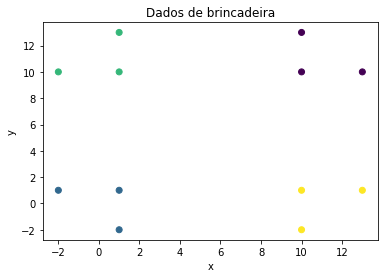

In [3]:
dados = [
    [10,10],
    [10,13],
    [13,10],
    
    [1,1],
    [-2,1],
    [1,-2],
    
    [1,10],
    [1,13],
    [-2,10],
    
    [10,-2],
    [10,1],
    [13,1]
]

labels = [
    0,
    0,
    0,
    
    1,
    1,
    1,
    
    2,
    2,
    2,
    
    3,
    3,
    3
]

qtd_classes = len(set(labels))


x = [d[0] for d in dados]
y = [d[1] for d in dados]
plt.scatter(x,y, c=labels)
plt.title("Dados de brincadeira")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [4]:
"""
CONFIGURAÇÕES: 

quantidade de camadas,
quantidade de neurônios em cada camada,
função de ativação
"""

dimensoes_camadas = [2,3,4]


In [5]:
rede = gerar_rede(dimensoes_camadas)

for _ in range(1000):
    erros = []
    
    for dado in range(len(dados)):
        # Atualizar os pesos: joga dados[dado] na entrada, e propaga o erro
        # pra ajustar os pesos
        rede = forward_backward(rede, dados[dado], one_hot(labels[dado], qtd_classes))
        
        # com os novos pesos, vamos ver o que ele prediz
        I, Y = forward(rede, dados[dado])
        d = one_hot(labels[dado], qtd_classes)
        
        # vamos guardar o erro entre o que ele previu e o que é pra ser
        erros.append(erro_total(Y[-1], d))
        
    if _ % 200 == 0:
        print("erro medio: ", sum(erros)/len(erros))

erro medio:  0.6135463033023872
erro medio:  0.00746700065208452
erro medio:  0.0034915307277833553
erro medio:  0.0022598867062362696
erro medio:  0.0016654341548461486


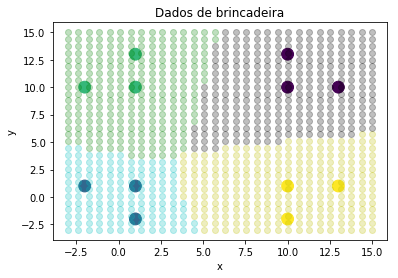

In [6]:
plt.title("Dados de brincadeira")
plt.xlabel("x")
plt.ylabel("y")

# 'ko' é uma bolinha preta, 'yo' é uma bolinha amarela
# vou jogar um dado na função predizer(), que vai me retornar
# 0 ou 1. Esse retorno eu uso pra escolher a cor
cores = ['ko', 'co', 'go', 'yo']

resolucao = 30

for xi in np.linspace(-3,15,resolucao):
    for yi in np.linspace(-3, 15, resolucao):
        cor = cores[predizer(rede, [xi, yi])]
        plt.plot(xi, yi, cor, alpha=0.25)
        
        
x = [d[0] for d in dados]
y = [d[1] for d in dados]
plt.scatter(x,y, c=labels, s=140)
plt.show()